In [1]:
import pandas as pd
import numpy as np

from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from PIL import Image
# import mpldatacursor

from PIL import Image
from PyPDF2 import PdfReader
from matplotlib.widgets import Cursor, SpanSelector

# import pytesseract
import easyocr
import keras_ocr
from keras_ocr.tools import drawAnnotations
import re
import os
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'PyPDF2'

In [2]:
!pip install PyPDF2

     ------------------------------------- 232.6/232.6 kB 13.9 MB/s eta 0:00:00


### Extracting Images from the PDF

In [ ]:
def extract_images_from_pdf(pdf_path, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Load the PDF file
    pdf_reader = PdfReader(pdf_path)

    # Loop through each page of the PDF
    for page_number, page in enumerate(pdf_reader.pages):
        # Extract images from the page
        xObject = page['/Resources']['/XObject'].get_object()
        image_counter = 0

        for obj in xObject:
            if xObject[obj]['/Subtype'] == '/Image':
                size = (xObject[obj]['/Width'], xObject[obj]['/Height'])
                data = xObject[obj].get_object()

                if '/Filter' in data:
                    if data['/Filter'] == '/FlateDecode':
                        img = Image.frombytes('RGB', size, data.get_data())
                        img.save(os.path.join(output_folder, f"page_{page_number + 1}_image_{image_counter}.png"))
                        image_counter += 1
                    elif data['/Filter'] == '/DCTDecode':
                        img = open(os.path.join(output_folder, f"page_{page_number + 1}_image_{image_counter}.jpg"), "wb")
                        img.write(data.get_data())
                        img.close()
                        image_counter += 1


In [ ]:
pdf_file_path = "C:/Users/JubinMohanty/Desktop/OCR_models/data/Jewelosco.pdf"
output_image_folder_path = "C:/Users/JubinMohanty/Desktop/OCR_models\data\image"

extract_images_from_pdf(pdf_file_path, output_image_folder_path)

### Trying some approaches to extract text from images:

- pytesseract
- easyocr
- keras_ocr

### Displaying the image

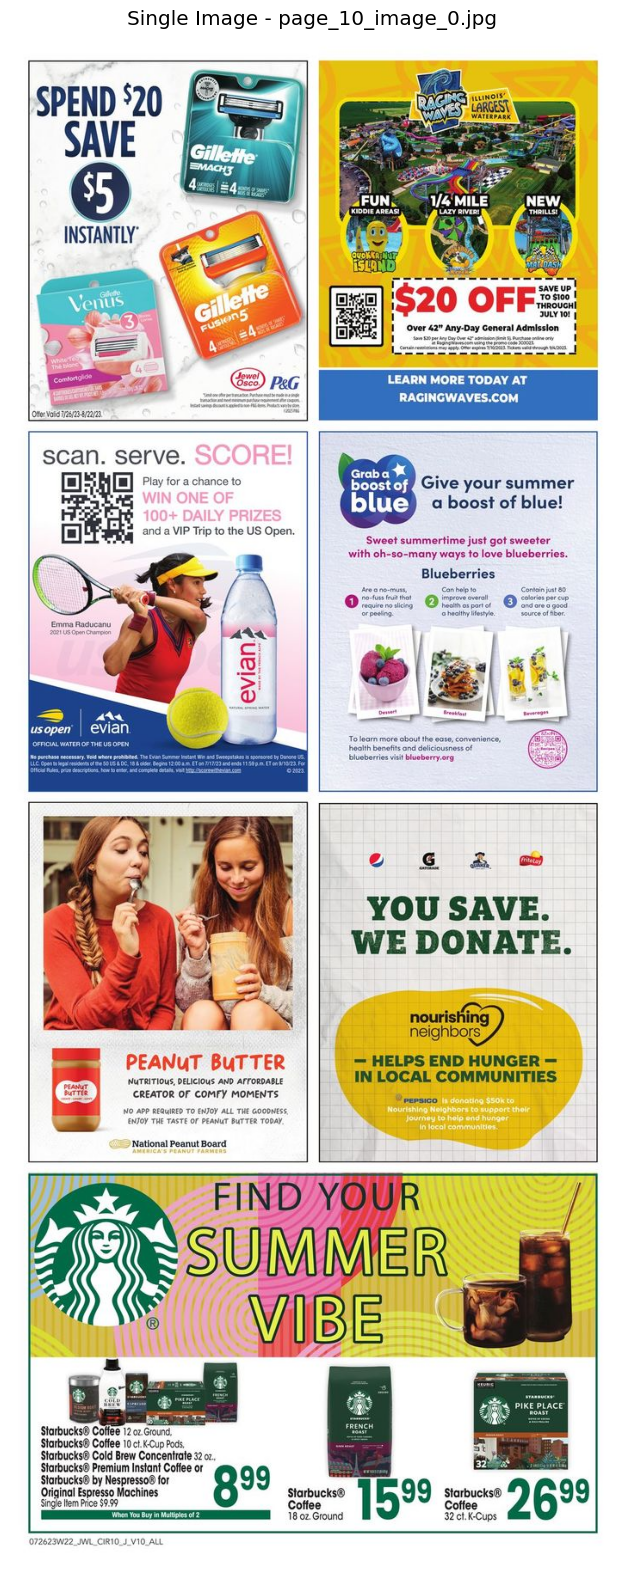

In [4]:
image_files = glob('C:/Users/JubinMohanty/Desktop/OCR_models/data/image/*')
# Check if the image file exists
if os.path.exists(image_files[0]):
    # Load the image
    img = Image.open(image_files[0])

    # Create a single subplot for the image
    fig, ax = plt.subplots(figsize=(20, 20))

    # Display the image
    ax.imshow(img)
    ax.set_title(f'Single Image - {os.path.basename(image_files[0])}')
    ax.axis('off')

    # Show the plot
    plt.show()
else:
    print(f"Image not found: {image_files[0]}")

### Method 1: pytesseract

In [7]:
# Example call
print(pytesseract.image_to_string(image_files[1], lang='eng'))

### EasyOCR

In [5]:
image_files = glob('C:/Users/JubinMohanty/Desktop/OCR_models/data/image/*')

In [6]:
reader = easyocr.Reader(['en'], gpu = True)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [7]:
t_img = len(image_files)

##### Performed some testing and analysis on images

In [349]:
results = reader.readtext(image_files[8])

In [350]:
# Create the DataFrame
bbox_df = pd.DataFrame(results, columns=['bbox', 'text', 'conf'])

In [477]:
# Convert the 'text' column to lowercase and filter rows where the lowercase text starts with the strings
filtered_df = bbox_df[bbox_df['text'].str.lower().str.startswith(('digh', 'reb', 'digital', 'coup', 'dig'), na=False)]

In [408]:
strings_list = ['digital rebate', 'digital coupon']

# Find the maximum length among the given strings
max_length = max(len(s) for s in strings_list)

In [409]:
# Filter the DataFrame based on the maximum length
filtered_df = filtered_df[filtered_df['text'].str.len() <= max_length]

In [478]:
filtered_df

bbox    text      conf
255  [[357, 1255], [401, 1255], [401, 1267], [357, ...  COUPON  0.987229
256  [[463, 1253], [507, 1253], [507, 1267], [463, ...  REBATE  0.838415
257  [[569, 1253], [613, 1253], [613, 1267], [569, ...  REBATE  0.532097
278   [[25, 1445], [71, 1445], [71, 1457], [25, 1457]]  DIghAl  0.155563
279  [[155, 1445], [203, 1445], [203, 1457], [155, ...  DIGgal  0.328108
280   [[25, 1455], [77, 1455], [77, 1469], [25, 1469]]  COUPON  0.612128
281  [[157, 1455], [209, 1455], [209, 1469], [157, ...  COUPON  0.974259

In [411]:
import re
img_id = image_files[12].split('\\')[1]
# Use regular expression to extract the number after "page_"
page_number = re.search(r'page_(\d+)', img_id).group(1)
filtered_df['page_number'] = page_number

In [412]:
len(filtered_df['bbox'].values[0])

4

In [413]:
filtered_df

bbox    text      conf  \
255  [[357, 1255], [401, 1255], [401, 1267], [357, ...  COUPON  0.987229   
256  [[463, 1253], [507, 1253], [507, 1267], [463, ...  REBATE  0.838415   
257  [[569, 1253], [613, 1253], [613, 1267], [569, ...  REBATE  0.532097   
278   [[25, 1445], [71, 1445], [71, 1457], [25, 1457]]  DIghAl  0.155563   
279  [[155, 1445], [203, 1445], [203, 1457], [155, ...  DIGgal  0.328108   
280   [[25, 1455], [77, 1455], [77, 1469], [25, 1469]]  COUPON  0.612128   
281  [[157, 1455], [209, 1455], [209, 1469], [157, ...  COUPON  0.974259   

    page_number  
255           9  
256           9  
257           9  
278           9  
279           9  
280           9  
281           9

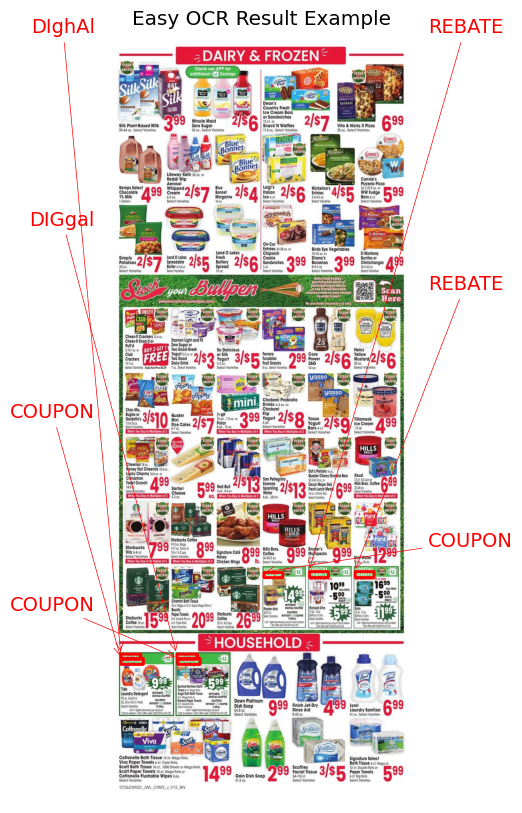

In [414]:
fig, ax = plt.subplots(figsize=(10, 10))

easy_results = filtered_df[['text','bbox']].values.tolist()
# print(easy_results)

easy_results = [(x[0], np.array(x[1])) for x in easy_results]
# print(easy_results)

keras_ocr.tools.drawAnnotations(plt.imread(image_files[8]), easy_results, ax=ax)

ax.set_title('Easy OCR Result Example')

# Save the annotated image with improved quality
output_file = 'C:/Users/JubinMohanty/Desktop/OCR_models/data/output_easy_ocr/annotated_image.jpg'
plt.savefig(output_file, dpi=300)

plt.show()

#### Checking if the strings are close to one another , if yes then merge it
**Calculated the central distance**

In [415]:
def horizontal_distance(bbox1, bbox2):
    x1, y1 = bbox1[0]
    x2, y2 = bbox1[1]
    x3, y3 = bbox2[0]
    x4, y4 = bbox2[1]

    center1_x = (x1 + x2) / 2
    center2_x = (x3 + x4) / 2
    return abs(center1_x - center2_x)

In [416]:
filtered_df_copy = filtered_df.copy()

In [417]:
# Group bounding boxes that are close horizontally and aggregate the 'text' column as a single string
grouped_text = []
grouped_conf = []
grouped_indices = []  # To keep track of already grouped indices
group_threshold = 20  # Adjust this threshold as needed based on the data

for idx, row in filtered_df_copy.iterrows():
    if idx in grouped_indices:
        continue  # Skip if the current row is already grouped

    text = row['text']
    conf = row['conf']
    grouped = False

    # Group rows that are close horizontally
    group_rows = [idx]  # List to hold the indices of the grouped rows
    for _, row2 in filtered_df_copy.iterrows():
        if _ == idx or _ in grouped_indices:
            continue  # Skip if the current row is itself or already grouped
        if horizontal_distance(row['bbox'], row2['bbox']) <= group_threshold:
            print(_, idx)
            text += ' ' + row2['text']
            filtered_df_copy.at[idx, 'text'] = text
            filtered_df_copy = filtered_df_copy.drop(_)

            conf = max(conf, row2['conf'])
            filtered_df_copy.at[idx, 'conf'] = conf
            grouped_indices.append(_)
            group_rows.append(_)
            grouped = True

    if grouped:
        grouped_text.append(text)
        grouped_conf.append(conf)
        grouped_indices.append(idx)
        print(grouped_text)
        print(grouped_conf)

grouped_data = {'text': grouped_text, 'conf': grouped_conf}
grouped_df = pd.DataFrame(grouped_data)


280 278
['DIghAl COUPON']
[0.612128262933616]
281 279
['DIghAl COUPON', 'DIGgal COUPON']
[0.612128262933616, 0.97425880011105]


In [448]:
grouped_indices

[280, 278, 281, 279]

In [698]:
filtered_df_copy

bbox           text  \
255  [[357, 1255], [401, 1255], [401, 1267], [357, ...         COUPON   
256  [[463, 1253], [507, 1253], [507, 1267], [463, ...         REBATE   
257  [[569, 1253], [613, 1253], [613, 1267], [569, ...         REBATE   
278   [[25, 1445], [71, 1445], [71, 1457], [25, 1457]]  DIghAl COUPON   
279  [[155, 1445], [203, 1445], [203, 1457], [155, ...  DIGgal COUPON   

         conf page_number  
255  0.987229           9  
256  0.838415           9  
257  0.532097           9  
278  0.612128           9  
279  0.974259           9

In [446]:
filtered_df

Empty DataFrame
Columns: [bbox, text, conf, page_number]
Index: []

### For all images using OCR

In [672]:
dfs = []
for img in image_files:
    result = reader.readtext(img)
    img_df = pd.DataFrame(result, columns=['bbox','text','conf'])

    # Convert the 'text' column to lowercase and filter rows where the lowercase text starts with the strings
    filtered_df = img_df[img_df['text'].str.lower().str.startswith(('digh', 'reb', 'digital', 'coup', 'dig'), na=False)]
    strings_list = ['digital rebate', 'digital coupon']
    # Find the maximum length among the given strings
    max_length = max(len(s) for s in strings_list)
    # Filter the DataFrame based on the maximum length
    filtered_df = filtered_df[filtered_df['text'].str.len() <= max_length]

    ##Getting the page number
    img_id = img.split('\\')[1]
    page_number = re.search(r'page_(\d+)', img_id).group(1)
    print(page_number)
    filtered_df['page_number'] = page_number

    # Check if each string in the 'text' column has exactly two words
    word_count = filtered_df['text'].str.split().apply(len)
    has_second_string = word_count == 2
    
    # Drop the rows where the 'text' column has more than two words
    filtered_df = filtered_df[~(word_count > 2)]

    # Filter rows where there is a second string and it's not 'coupon' or 'rebate'
    # filtered_df = filtered_df[(filtered_df['text'].apply(has_second_string)) & (filtered_df['text'].apply(second_string_check))]

    # Apply the function to create a new column 'words_satisfy_condition'
    # filtered_df['words_satisfy_condition'] = filtered_df['text'].apply(check_words_length)

    # Drop the rows where 'words_satisfy_condition' is False
    filtered_df = filtered_df[filtered_df['words_satisfy_condition']]

    print(filtered_df)

    # Drop the 'words_satisfy_condition' column as it is no longer needed
    # filtered_df.drop(columns=['words_satisfy_condition'], inplace=True)

    dfs.append(filtered_df)

easyocr_df = pd.concat(dfs)

10


KeyError: 'words_satisfy_condition'

In [752]:
import pandas as pd

# Define the functions

# Function to check if the second word is not 'coupon' or 'rebate'
def check_second_word(text):
    words = text.lower().split()
    if len(words)==2:
        return words[1] in ['coupon', 'rebate']
    else:
        return True


def check_length(text):
    w_text = text.lower().split()
    words = max(len('coupon'), len('rebate'), len('digital'))
    # print('Threshold length:',words)
    if len(w_text) == 1:
        # print('Actual Word Length:', len(w_text[0]))
        return len(w_text[0])<=words
    else:
        return True

# Your original code
dfs = []
for img in image_files:
    result = reader.readtext(img)
    img_df = pd.DataFrame(result, columns=['bbox','text','conf'])

    # Convert the 'text' column to lowercase and filter rows where the lowercase text starts with the strings
    filtered_df = img_df[img_df['text'].str.lower().str.startswith(('digh', 'reb', 'digital', 'coup', 'dig'), na=False)]
    strings_list = ['digital rebate', 'digital coupon']
    # Find the maximum length among the given strings
    max_length = max(len(s) for s in strings_list)
    # Filter the DataFrame based on the maximum length
    filtered_df = filtered_df[filtered_df['text'].str.len() <= max_length]

    ##Getting the page number
    img_id = img.split('\\')[1]
    page_number = re.search(r'page_(\d+)', img_id).group(1)
    print(page_number)
    filtered_df['page_number'] = page_number

    # Check if each string in the 'text' column has exactly two words
    word_count = filtered_df['text'].str.split().apply(len)
    has_second_string = word_count == 2
    
    # Drop the rows where the 'text' column has more than two words
    filtered_df = filtered_df[~(word_count > 2)]

    if not filtered_df.empty:

        # Filtering out records with "coupon" or "rebate" in the second string
        filtered_df = filtered_df[filtered_df['text'].apply(check_second_word)]
        # Apply the function on 'text_column' and create a boolean mask
        filtered_df = filtered_df[filtered_df['text'].apply(check_length)]

    #     # Use the mask to keep only the rows where the condition is True
    #     filtered_df = filtered_df[mask_length]

    dfs.append(filtered_df)

easyocr_df = pd.concat(dfs)


10
11
12
13
1
2
3
4
5
6
7
8
9


In [741]:
df123 = dfs.copy()

In [756]:
df123[1]

bbox            text  \
298   [[23, 1363], [77, 1363], [77, 1377], [23, 1377]]         DIGitAL   
299  [[137, 1363], [191, 1363], [191, 1377], [137, ...         DIGitaL   
301   [[25, 1375], [87, 1375], [87, 1391], [25, 1391]]          COUPON   
302  [[137, 1377], [199, 1377], [199, 1391], [137, ...          CouPOn   
338  [[559, 1591], [643, 1591], [643, 1607], [559, ...  DIgITAL COUPON   

         conf page_number  
298  0.349746          11  
299  0.386418          11  
301  0.978685          11  
302  0.142411          11  
338  0.369390          11

In [735]:
easyocr_df_copy = easyocr_df.copy()

In [753]:
easyocr_df_copy

'''

Sequence:

1: Ocr Algo
2. Got all anotations
3. Business rules added
4. Calculating distance of boxes (we have x,y cordinates), algo is already implemented, remove bug and clean it # To do by pawan
5. Makes sure you also have the empty dataframes in the list, such we can keep track of pages
6. Plot all the images, to see the boxes/annotation.
7. Mapping as per below description # To do by pawan
8. Create an aggregated dataframe to show counts. # To do by pawan


Before mapping merge using distance algo

Mapping:

Goal: To create a another data frame

'Digital Coupon' : 'Digital Coupon'
'Coupon' : 'Digital Coupon'
'rebate': 'Digital Rebate'
'DIghAl': 'Digital Coupon'
'DIGgal':'Digital Coupon'	

'''

# Columns
#{'Page NO', 'Digital Coupon', 'Digital Rebate'} 

bbox            text  \
298   [[23, 1363], [77, 1363], [77, 1377], [23, 1377]]         DIGitAL   
299  [[137, 1363], [191, 1363], [191, 1377], [137, ...         DIGitaL   
301   [[25, 1375], [87, 1375], [87, 1391], [25, 1391]]          COUPON   
302  [[137, 1377], [199, 1377], [199, 1391], [137, ...          CouPOn   
338  [[559, 1591], [643, 1591], [643, 1607], [559, ...  DIgITAL COUPON   
239   [[31, 1431], [71, 1431], [71, 1445], [31, 1445]]          DIghal   
240   [[31, 1441], [69, 1441], [69, 1453], [31, 1453]]          REBATE   
95    [[359, 935], [485, 935], [485, 955], [359, 955]]  DIGITAL COUPON   
255  [[357, 1255], [401, 1255], [401, 1267], [357, ...          COUPON   
256  [[463, 1253], [507, 1253], [507, 1267], [463, ...          REBATE   
257  [[569, 1253], [613, 1253], [613, 1267], [569, ...          REBATE   
278   [[25, 1445], [71, 1445], [71, 1457], [25, 1457]]          DIghAl   
279  [[155, 1445], [203, 1445], [203, 1457], [155, ...          DIGgal   
280   [[25, 1455], [77, 1455], [77, 1469], [25, 1469]]          COUPON   
281  [[157, 1455], [209, 1455], [209, 1469], [157, ...          COUPON   
245  [[195, 1343], [245, 1343], [245, 1357], [195, ...         DIGgial   
249  [[195, 1353], [251, 1353], [251, 1369], [195, ...          COUpOn   
295  [[361, 1545], [411, 1545], [411, 1559], [361, ...         digital   
297  [[361, 1557], [409, 1557], [409, 1571], [361, ...          REBATE   

         conf page_number  
298  0.349746          11  
299  0.386418          11  
301  0.978685          11  
302  0.142411          11  
338  0.369390          11  
239  0.303529           2  
240  0.943605           2  
95   0.818094           3  
255  0.987229           5  
256  0.838415           5  
257  0.532097           5  
278  0.155563           5  
279  0.328108           5  
280  0.612128           5  
281  0.974259           5  
245  0.160176           7  
249  0.300632           7  
295  0.678767           7  
297  0.993544           7

In [677]:
def horizontal_distance(bbox1, bbox2):
    x1, y1 = bbox1[0]
    x2, y2 = bbox1[1]
    x3, y3 = bbox2[0]
    x4, y4 = bbox2[1]

    center1_x = (x1 + x2) / 2
    center2_x = (x3 + x4) / 2
    return abs(center1_x - center2_x)

In [678]:
def merge_logic(df_img):
    # Group bounding boxes that are close horizontally and aggregate the 'text' column as a single string
    grouped_text = []
    grouped_conf = []
    grouped_indices = set()  # Use a set to keep track of already grouped indices
    rows_to_drop = []  # List to store the rows that need to be dropped
    group_threshold = 20  # Adjust this threshold as needed based on the data

    for idx, row in df_img.iterrows():
        if idx in grouped_indices or idx in rows_to_drop:
            continue  # Skip if the current row is already grouped or marked for dropping

        text = row['text']
        conf = row['conf']
        grouped = False

        # Group rows that are close horizontally
        group_rows = [idx]  # List to hold the indices of the grouped rows
        for _, row2 in df_img.iterrows():
            if _ == idx or _ in grouped_indices or _ in rows_to_drop:
                continue  # Skip if the current row is itself, already grouped, or marked for dropping
            if horizontal_distance(row['bbox'], row2['bbox']) <= group_threshold:
                text += ' ' + row2['text']
                conf = max(conf, row2['conf'])
                group_rows.append(_)
                grouped = True

        if grouped:
            grouped_text.append(text)
            grouped_conf.append(conf)
            grouped_indices.update(group_rows)
            rows_to_drop.extend(group_rows[1:])  # Exclude the first row since it's already in grouped_text
        else:
            grouped_text.append(text)
            grouped_conf.append(conf)

    grouped_data = {'text': grouped_text, 'conf': grouped_conf}
    grouped_df = pd.DataFrame(grouped_data)

    # Create a new DataFrame without the rows that were merged
    fil_df = df_img.drop(rows_to_drop)

    return fil_df, grouped_df


In [595]:
def merge_logic(df_img):
    # Group bounding boxes that are close horizontally and aggregate the 'text' column as a single string
    grouped_text = []
    grouped_conf = []
    grouped_indices = []  # To keep track of already grouped indices
    group_threshold = 20  # Adjust this threshold as needed based on the data

    for idx, row in df_img.iterrows():
        if idx in grouped_indices:
            continue  # Skip if the current row is already grouped

        text = row['text']
        conf = row['conf']
        grouped = False

        # Group rows that are close horizontally
        group_rows = [idx]  # List to hold the indices of the grouped rows
        for _, row2 in df_img.iterrows():
            if _ == idx or _ in grouped_indices:
                continue  # Skip if the current row is itself or already grouped
            if horizontal_distance(row['bbox'], row2['bbox']) <= group_threshold:
                # print(_, idx)
                text += ' ' + row2['text']
                df_img.at[idx, 'text'] = text
                df_img = df_img.drop(_)

                conf = max(conf, row2['conf'])
                df_img.at[idx, 'conf'] = conf
                grouped_indices.append(_)
                group_rows.append(_)
                grouped = True

        if grouped:
            grouped_text.append(text)
            grouped_conf.append(conf)
            grouped_indices.append(idx)
            # print(grouped_text)
            # print(grouped_conf)
            
    grouped_data = {'text': grouped_text, 'conf': grouped_conf}
    grouped_df = pd.DataFrame(grouped_data)

    return df_img, grouped_df


### Look into this and solve it 

In [662]:
df_report = []
for df in df123:
    if not df.empty:  # Check if the DataFrame is not empty
        print('Algo has captured the target...')
        fil_df, grouped_df = merge_logic(df)
        df_report.append(fil_df)
        
        # print(filtered_df)
        # df_report.append(filtered_df)
    else:
        print(f"Skipping index {index} as the DataFrame is empty.")
        df_report.append(pd.DataFrame())

Skipping index 0 as the DataFrame is empty.
Algo has captured the target...
Skipping index 0 as the DataFrame is empty.
Skipping index 0 as the DataFrame is empty.
Skipping index 0 as the DataFrame is empty.
Algo has captured the target...
Skipping index 0 as the DataFrame is empty.
Skipping index 0 as the DataFrame is empty.
Algo has captured the target...
Skipping index 0 as the DataFrame is empty.
Algo has captured the target...
Skipping index 0 as the DataFrame is empty.
Skipping index 0 as the DataFrame is empty.


In [664]:
# df_report

In [609]:
dfs[1]

bbox            text  \
298   [[23, 1363], [77, 1363], [77, 1377], [23, 1377]]  DIGitAL COUPON   
299  [[137, 1363], [191, 1363], [191, 1377], [137, ...         DIGitaL   
301   [[25, 1375], [87, 1375], [87, 1391], [25, 1391]]          COUPON   
302  [[137, 1377], [199, 1377], [199, 1391], [137, ...          CouPOn   

         conf page_number  
298  0.349746          11  
299  0.386418          11  
301  0.978685          11  
302  0.142411          11

In [754]:
def plot_compare(img_fn, easyocr_df, count):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    easy_results = easyocr_df[['text','bbox']].values.tolist()
    # print(easy_results)

    easy_results = [(x[0], np.array(x[1])) for x in easy_results]
    keras_ocr.tools.drawAnnotations(plt.imread(img_fn), easy_results, ax=ax)
    ax.set_title('Easy OCR Result Example')

    # Save the annotated image with improved quality
    output_file = f'C:/Users/JubinMohanty/Desktop/OCR_models/data/output_easy_ocr/annotated_image_{count}.jpg'
    plt.savefig(output_file, dpi=300)

    plt.show()

Skipping index 0 as the DataFrame is empty.
Algo has captured the target...
1


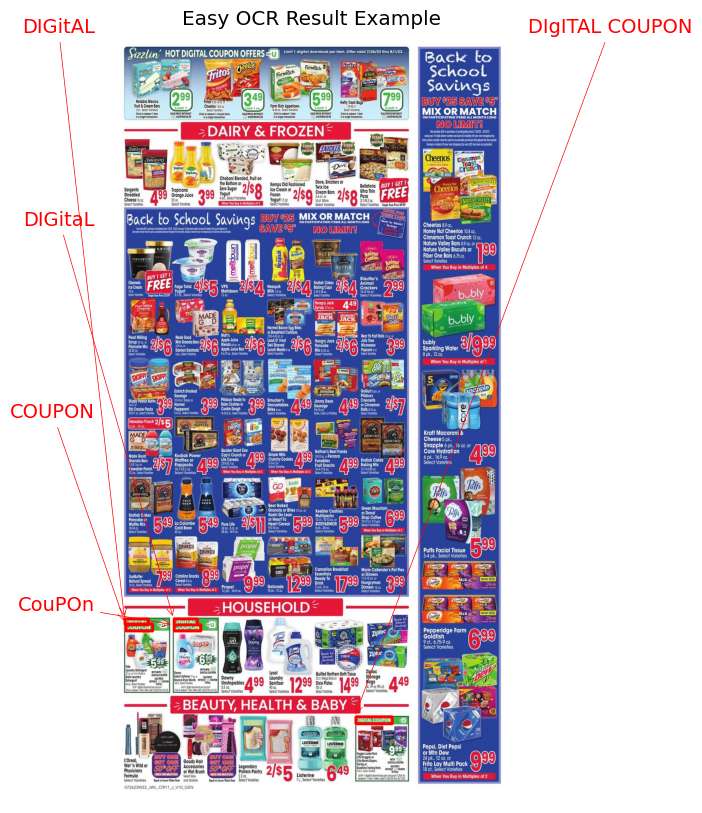

Skipping index 2 as the DataFrame is empty.
Skipping index 3 as the DataFrame is empty.
Skipping index 4 as the DataFrame is empty.
Algo has captured the target...
5


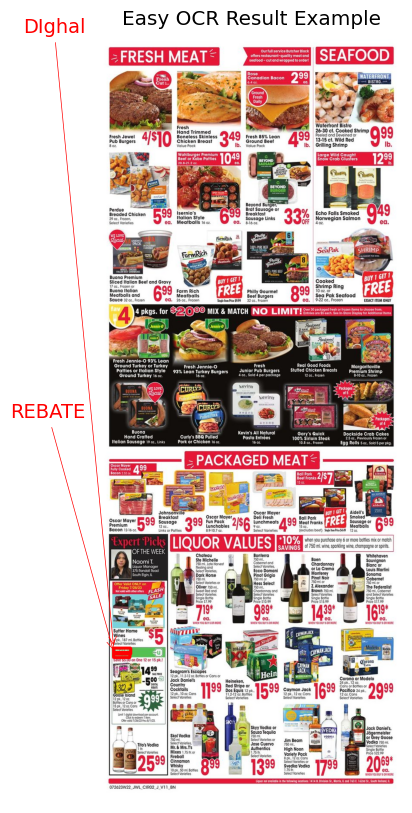

Algo has captured the target...
6


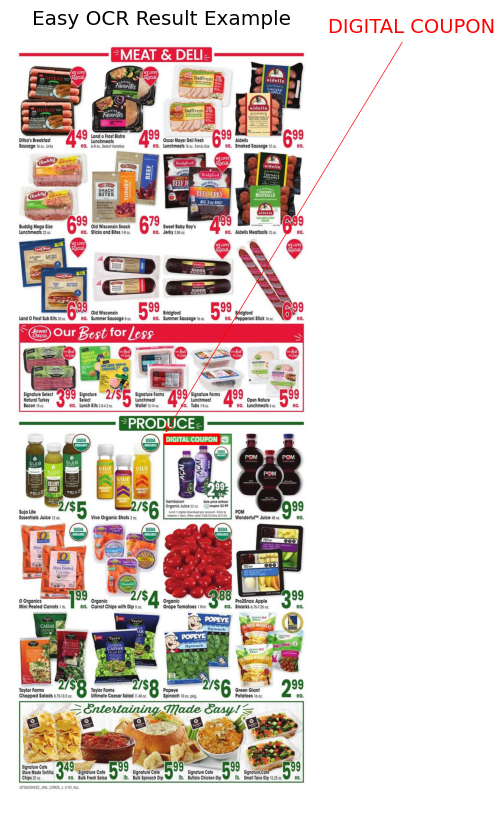

Skipping index 7 as the DataFrame is empty.
Algo has captured the target...
8


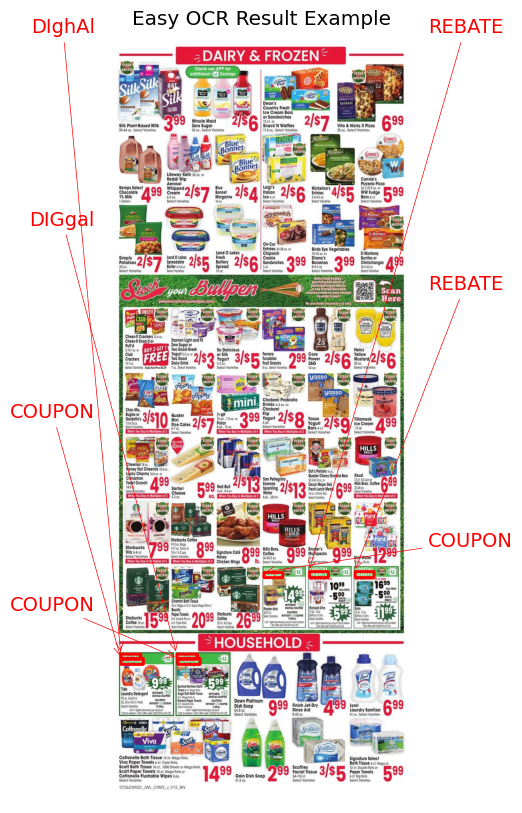

Skipping index 9 as the DataFrame is empty.
Algo has captured the target...
10


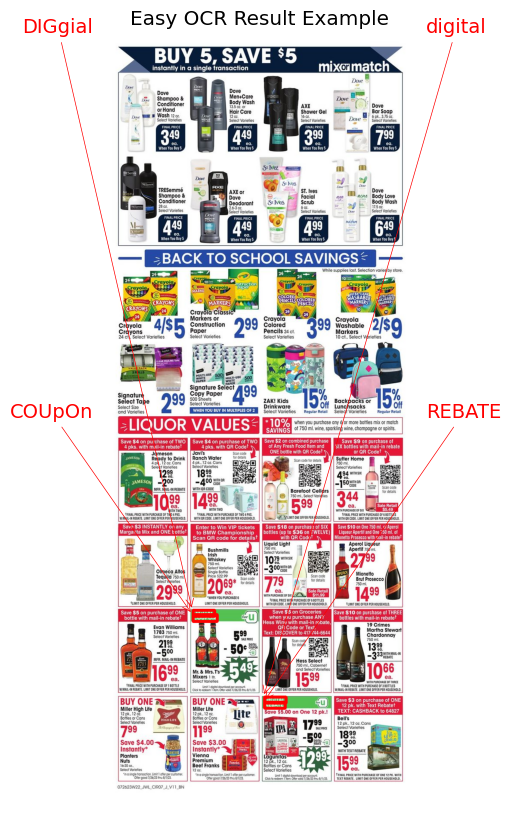

Skipping index 11 as the DataFrame is empty.
Skipping index 12 as the DataFrame is empty.


In [755]:
# df_repor = []
for index, img_path in enumerate(image_files):
    if not df123[index].empty:  # Check if the DataFrame is not empty
        print('Algo has captured the target...')
        print(index)
        plot_compare(img_path, df123[index], index)
        # filtered_df, grouped_df = merge_logic(dfs[index])
        # print(filtered_df)
        # df_report.append(filtered_df)
    else:
        print(f"Skipping index {index} as the DataFrame is empty.")
    # print(index, val)

### Condition to check
1. Check 2nd string should not be different from coupon and rebate
2. Merge using above distance algo
3. Once you are done with the final df, inform me.

### Method 3: Keras_ocr

In [690]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for C:\Users\JubinMohanty\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\JubinMohanty\.keras-ocr\crnn_kurapan.h5


In [691]:
results = pipeline.recognize([image_files[1]])

22/22 [==============================] - 52s 2s/step


In [692]:
df_keras_ocr = pd.DataFrame(results[0], columns=['text', 'bbox'])

# Convert the 'text' column to lowercase and filter rows where the lowercase text starts with 'digital'
filtered_df = df_keras_ocr[df_keras_ocr['text'].str.lower().str.startswith('digital', na=False)]

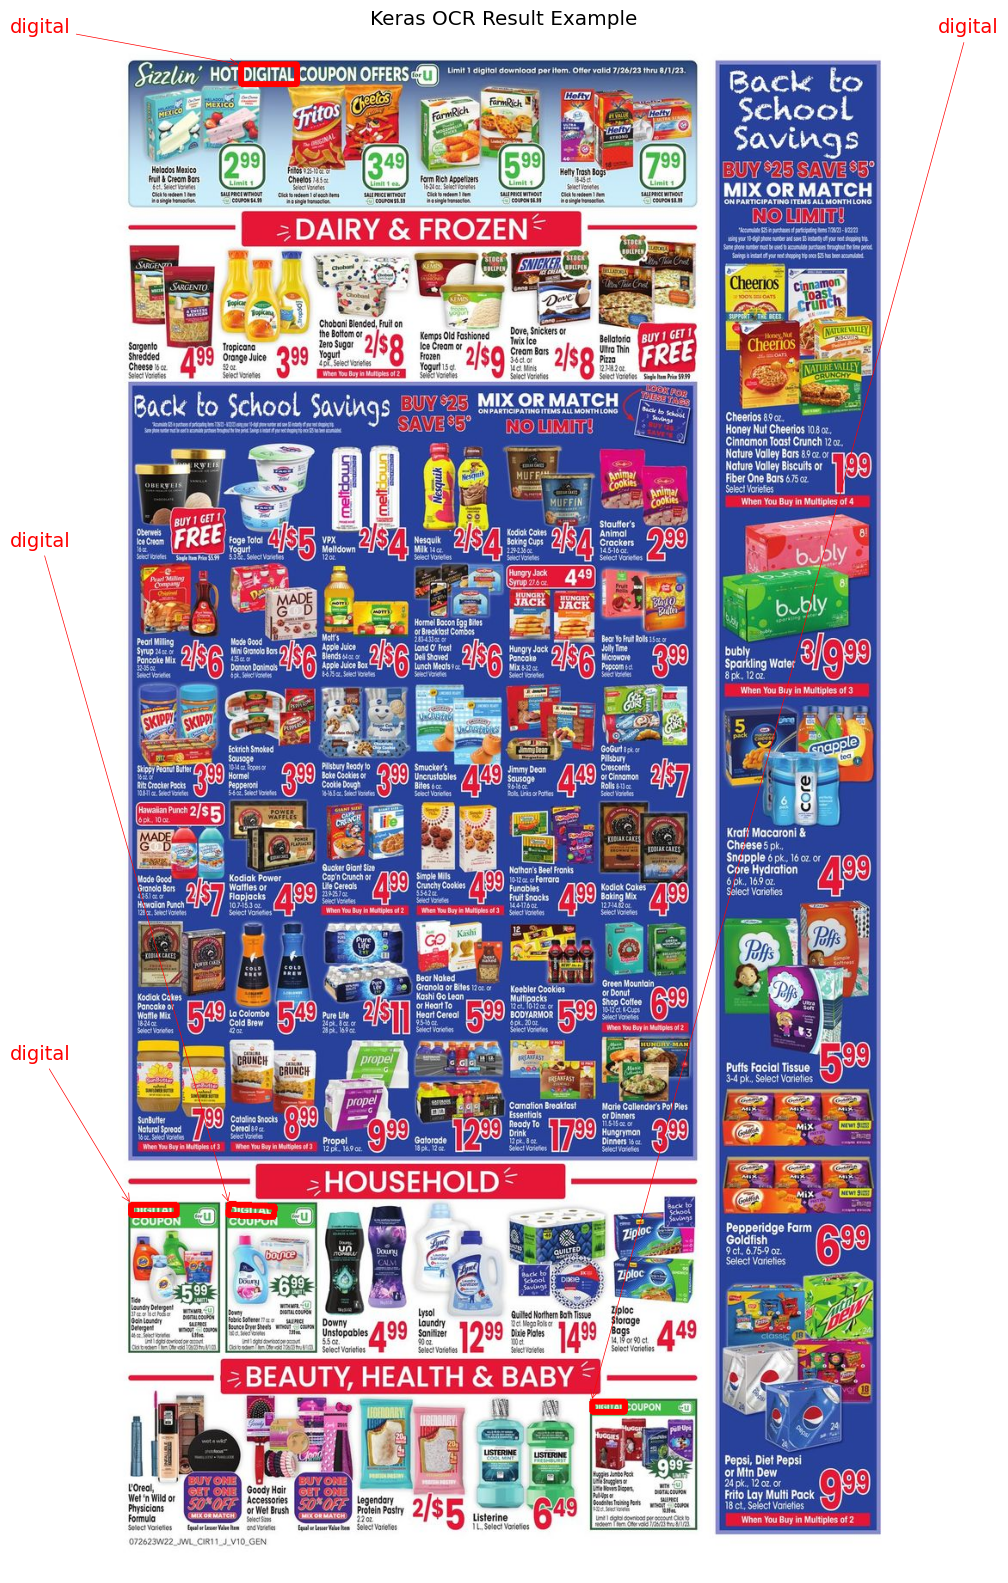

In [693]:
fig, ax = plt.subplots(figsize=(20, 20))

keras_results = filtered_df[['text','bbox']].values.tolist()
keras_results = [(x[0], np.array(x[1])) for x in keras_results]

keras_ocr.tools.drawAnnotations(plt.imread(image_files[1]), keras_results, ax=ax)

ax.set_title('Keras OCR Result Example')

# Save the annotated image with improved quality
output_file = 'C:/Users/JubinMohanty/Desktop/OCR_models/data/output_keras_ocr/annotated_image.jpg'
plt.savefig(output_file, dpi=300)

plt.show()